In [2]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt

from qec_util.performance import plots, confidence_interval_binomial
from qec_util.samplers import read_failures_from_file
from surface_sim.models import SI1000NoiseModel
from lomatching import MoMatching
from mle_decoder import MLEDecoder

In [3]:
import matplotlib
import matplotlib.ticker as ticker

matplotlib.rcParams.update(
    {
        "font.size": 11,
        "font.family": "cmr10",
        "font.weight": "normal",
        'axes.unicode_minus': False,
        "axes.formatter.use_mathtext": True,
        "text.usetex": True,
        "axes.formatter.limits": (0,0),
    }
)

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

int_to_alph = {i: s for i, s in enumerate("abcdefghijklmnopqrstuvwxyz")}

In [4]:
# INPUTS
FILE_NAME = "20250130_cliffords_modulo_paulis_and_swap.txt"
EXPERIMENTS = [0, 248]
DISTANCES = [3]
PROBS = [0.001, 0.002, 0.003, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.008, 0.01]
NOISE_MODEL = SI1000NoiseModel
BASES = ["Z", "X"]
FRAMES = ["pre-gate"]
DECODERS = [MLEDecoder, MoMatching]

# DATA STORAGE
NAME_FORMAT = "{exp_name}_{noise_model}_{decoder}_d{distance}_b{basis}_f{frame}_s0_p{prob:0.10f}.txt"
DATA_DIR = pathlib.Path(f"data_{FILE_NAME.replace('.txt', '')}")
PLOTS_DIR = pathlib.Path("plots")

In [5]:
if not PLOTS_DIR.exists():
    PLOTS_DIR.mkdir()

In [7]:
NUM_FAILURES = np.zeros((len(DECODERS), len(EXPERIMENTS), len(BASES), len(FRAMES), len(DISTANCES), len(PROBS)))
NUM_SAMPLES = np.zeros((len(DECODERS), len(EXPERIMENTS), len(BASES), len(FRAMES), len(DISTANCES), len(PROBS)))

for d, decoder in enumerate(DECODERS):
    for i, experiment_name in enumerate(EXPERIMENTS):
        for j, basis in enumerate(BASES):
            for k, frame in enumerate(FRAMES):
                for l, distance in enumerate(DISTANCES):
                    for m, prob in enumerate(PROBS):
                        file_name = NAME_FORMAT.format(
                           exp_name=experiment_name,
                           noise_model=NOISE_MODEL.__name__,
                           distance=distance,
                           basis=basis,
                           frame=frame,
                           prob=prob,                       
                           decoder=decoder.__name__,       
                        )
                        
                        num_failures, num_samples, extra = read_failures_from_file(DATA_DIR / file_name)
                        NUM_FAILURES[d, i,j,k,l,m] = num_failures
                        NUM_SAMPLES[d, i,j,k,l,m] = num_samples

LOG_PROB = NUM_FAILURES / NUM_SAMPLES
LOG_PROB_LOWER, LOG_PROB_UPPER = confidence_interval_binomial(NUM_FAILURES, NUM_SAMPLES)

In [8]:
print((NUM_SAMPLES != 0).sum())
assert (NUM_SAMPLES != 0).all()

96


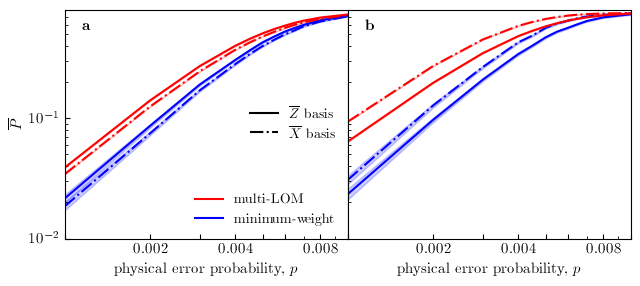

In [9]:
fig, axes = plt.subplots(ncols=len(EXPERIMENTS), figsize=cm2inch(16, 7))

num_circuits = len(EXPERIMENTS)

color = {d: c for d, c in zip(DECODERS, ["blue", "red"])}
for d, decoder in enumerate(DECODERS):
    for i, experiment_name in enumerate(EXPERIMENTS):
        ax = axes[i]
        for k, frame in enumerate(FRAMES):
            marker_basis = ["s", "*"]
            for j, basis in enumerate(BASES):
                for l, distance in enumerate(DISTANCES):
                    ax.plot(PROBS, LOG_PROB[d,i,j,k,l], "-" if basis == "Z" else "-.", color=color[decoder])
                    ax.fill_between(PROBS, LOG_PROB_LOWER[d,i,j,k,l], LOG_PROB_UPPER[d,i,j,k,l], color=color[decoder], alpha=0.2)

for ax in axes:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("physical error probability, $p$")
    ax.set_ylabel("$\\overline{P}$")
    ax.set_ylim(1e-2, 0.8)
    ax.set_xlim(2e-3, 9e-3)
    ax.tick_params(direction="in", which="major")
    ax.tick_params(direction="in", which="minor")
    
    xticks =      [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.009]
    xticklabels = [0.002, 0.003,    "", 0.005,    "", 0.007, 0.009]
    xticks =      [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.010]
    xticklabels = [0.001,    "", 0.003,    "", 0.005,    "",    "", 0.010]
    xticks =      [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.008, 0.010]
    xticklabels = [   "", 0.002,    "", 0.004,    "",    "", 0.008,    ""]
    ax.set_xticks(xticks)
    ax.set_xticklabels(map(str, xticklabels))

ax = axes[1]
ax.set_ylabel("")
ax.set_yticks([])
ax.set_yticklabels([])

axes[0].text(0.00115, 0.55, "\\textbf{a}")
axes[1].text(0.00115, 0.55, "\\textbf{b}")

ax = axes[0]
lines = []
for d, decoder in enumerate(DECODERS[::-1]):
    if decoder == MoMatching:
        label = "multi-LOM"
    elif decoder == MLEDecoder:
        label = "minimum-weight"
    line, = ax.plot([], [], color=color[decoder], linestyle="-", label=label)
    lines.append(line)
legend = ax.legend(handles=lines, loc="lower right", fontsize=10, frameon=False)
ax.add_artist(legend)

line1, = ax.plot([], [], color="black", linestyle="-", label="$\\overline{Z}$ basis")
line2, = ax.plot([], [], color="black", linestyle="-.", label="$\\overline{X}$ basis")
ax.legend(handles=[line1, line2], loc="center right", fontsize=10, frameon=False)

fig.tight_layout(pad=0.30)
plt.subplots_adjust(wspace=.0)
fig.savefig(PLOTS_DIR / "threshold_plot_2q-cliffords_circ-level-noise_MLE_SI1000.pdf", format="pdf")
plt.show()